In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Importar el database
cancer=pd.read_csv('breast-cancer.csv')

#Ordenar database de acuerdo a diagnosis (Benigno, Maligno)
cancer = cancer.sort_values(by='diagnosis')

#Seleccionar los datos que necesitamos de Benigno
Benigno = cancer.iloc[0:70,[2,3,4,1]]

#Reemplazamos los datos por 1 la salida Benigno (B)
Benigno.diagnosis=Benigno.diagnosis.str.strip()
Benigno.loc[Benigno.diagnosis=='B','diagnosis']=0

#Obtenemos los 20 primeros datos con salida Benigno (0)
MatrizEntrenamientoB=Benigno.iloc[0:20,0:Benigno.columns.size].values

#Obtenemos los 50 datos restantes con salida Benigno (0)
MatrizValidacionB=Benigno.iloc[20:70,0:Benigno.columns.size].values

#Seleccionar los datos que necesitamos de Maligno
Maligno=cancer.iloc[358:428,[2,3,4,1]]

#Reemplazamos los datos por 0 la salida Maligno (M)
Maligno.diagnosis=Maligno.diagnosis.str.strip()
Maligno.loc[Maligno.diagnosis=='M','diagnosis']=1

#Obtenemos los 20 primeros datos con salida Maligno (1)
MatrizEntrenamientoM=Maligno.iloc[0:20,0:Maligno.columns.size].values

#Obtenemos los 50 datos restantes con salida Maligno (1)
MatrizValidacionM=Maligno.iloc[20:70,0:Maligno.columns.size].values

#Concatenar las matrices resultantes
MatrizEntrenamiento=np.concatenate((MatrizEntrenamientoB, MatrizEntrenamientoM))
MatrizValidacion=np.concatenate((MatrizValidacionB,MatrizValidacionM))

# Separar los datos para entrenamiento y validación

In [4]:
#Obtener matriz con únicamente las entradas
def SepararEntradas(Matriz):
    MatrizEntradas = np.delete(Matriz,-1,axis=1)
    MatrizEntradas = MatrizEntradas.astype(float)
    return MatrizEntradas

#Obtener matriz con únicamente las salidas
def SepararSalidas(Matriz):
    MatrizSalidas = np.array([fila[3] for fila in Matriz])
    return MatrizSalidas

#Separamos las entradas y las salidas en matrices diferentes
EntradasEnt = SepararEntradas(MatrizEntrenamiento)
SalidasEnt = SepararSalidas(MatrizEntrenamiento)

EntradasVal = SepararEntradas(MatrizValidacion)
SalidasVal = SepararSalidas(MatrizValidacion)

#Guardamos en variables el número de filas y columnas
FilaEntE,ColumnaEntE = EntradasEnt.shape
FilaValE,ColumnaValE = EntradasVal.shape

ColumnaEntS = SalidasEnt.shape
ColumnaValS = SalidasVal.shape

# Funciones

In [5]:
#Función sigmoide
def sigmoide(x):
    return 1/(1+np.exp(-x))

#Derivada de la sigmoide
def DerSigmoide(x):
    s = 1/(1+np.exp(-x))
    return s * (1-s)

# Globalización de variables

In [6]:
class PerceptronMulticapa():
    def __init__ (self, NeuEntrada, NeuSalida, PesoW1, PesoW2, ValBiaslSalida, ValBiasNeuOculta, PrecisionInicial, NumEpocas, FactorAprendizaje, NumEntradas, NeuCapaOculta):
        self.NeuEntrada = np.transpose(NeuEntrada)
        self.NeuSalida = NeuSalida
        self.PesoW1 = PesoW1
        self.PesoW2 = PesoW2
        self.ValBiaslSalida = ValBiaslSalida
        self.ValBiasNeuOculta = ValBiasNeuOculta
        self.PrecisionInicial = PrecisionInicial
        self.NumEpocas = NumEpocas
        self.FactorAprendizaje = FactorAprendizaje
        self.NumEntradas = NumEntradas
        self.NeuCapaOculta = NeuCapaOculta

        self.SalidaDeseada = 0
        self.ErrorTotalIteraciones = 1
        self.ErrorCuaMedio = 0
        self.ErrorAnterior = 0
        self.MatrizErrores = []
        self.ErrorActual = np.zeros((len(NeuSalida)))
        self.EntradasEnCeros = np.zeros((1,NumEntradas))
        self.PotencialActivacionNeuOcultas = np.zeros((NeuCapaOculta,1))
        self.FuncionActivacionNeuOcultas = np.zeros((NeuCapaOculta,1))
        self.PotencialActivacionNeuSalida = 0.0
        self.FuncionActivacionNeuSalida = 0.0
        self.ContadorEpocas = 0

        self.ErrorReal = 0
        self.DeltaSalida = 0.0
        self.DeltaNeuOculta = np.zeros((NeuCapaOculta,1))

    def Entrenamiento(self):
        MatrizErrores = []
        while(np.abs(self.ErrorTotalIteraciones) > self.PrecisionInicial):
            self.ErrorAnterior = self.ErrorCuaMedio
            for i in range(len(self.NeuSalida)):
                self.EntradasEnCeros = self.NeuEntrada[:,i]
                self.SalidaDeseada = self.NeuSalida[i]
                self.Propagation()
                self.BackPropagation()
                self.Propagation()
                self.ErrorActual[i] = (0.5)*((self.SalidaDeseada - self.FuncionActivacionNeuSalida)**2)
            self.Error()
            MatrizErrores.append(self.ErrorTotalIteraciones)
            self.ContadorEpocas +=1
            if self.ContadorEpocas > self.NumEpocas:
                break
        return self.ContadorEpocas, self.PesoW1, self.PesoW2, self.ValBiaslSalida, self.ValBiasNeuOculta, MatrizErrores

    def Propagation(self):
        #Operar en la primera capa
        for i in range(self.NeuCapaOculta):
            self.PotencialActivacionNeuOcultas[i,:] = np.dot(self.PesoW1[i,:], self.EntradasEnCeros) + self.ValBiasNeuOculta[i,:]
        
        #Cálculo de la activación de las neuronas en la capa oculta
        for j in range(self.NeuCapaOculta):
            self.FuncionActivacionNeuOcultas[j,:] = sigmoide(self.PotencialActivacionNeuOcultas[j,:])

        #Cálculo del potencial de activación de la neurona de salida
        self.PotencialActivacionNeuSalida = (np.dot(self.PesoW2,self.FuncionActivacionNeuOcultas)+ self.ValBiaslSalida)

        #Cálculo de salida de la neurona de salida
        self.FuncionActivacionNeuSalida = sigmoide(self.PotencialActivacionNeuSalida)

    def BackPropagation(self):
        #Calcular error
        self.ErrorReal = (self.SalidaDeseada - self.FuncionActivacionNeuSalida)
        
        self.DeltaSalida = (DerSigmoide (self.PotencialActivacionNeuSalida) * self.ErrorReal)

        self.PesoW2 = self.PesoW2 + (np.transpose(self.FuncionActivacionNeuOcultas) * self.FactorAprendizaje * self.DeltaSalida)

        self.ValBiaslSalida = self.ValBiaslSalida + (self.FactorAprendizaje * self.DeltaSalida)

        self.DeltaNeuOculta = DerSigmoide(self.PotencialActivacionNeuOcultas) * np.transpose(self.PesoW2) * self.DeltaSalida

        for i in range(self.NumEntradas):
            self.PesoW1[i,:] = self.PesoW1[i,:] + ((self.DeltaNeuOculta[i,:]) * self.EntradasEnCeros * self.FactorAprendizaje)
        
        for j in range(self.NumEntradas):
            self.ValBiasNeuOculta[j,:] = self.ValBiasNeuOculta[j,:] + (self.FactorAprendizaje * self.DeltaNeuOculta[j,:])

    def Error(self):
        self.ErrorCuaMedio = ((1/len(self.NeuSalida)) * (sum(self.ErrorActual)))
        self.ErrorTotalIteraciones = (self.ErrorCuaMedio - self.ErrorAnterior)
    
    def Validacion(self):
        MatrizInterna = np.zeros((len(self.NeuSalida),1))
        for i in range(len(self.NeuSalida)):
            self.EntradasEnCeros = self.NeuEntrada[:,i]
            self.Propagation()
            MatrizInterna[i,:] = self.FuncionActivacionNeuSalida
        return MatrizInterna.tolist()


In [7]:
def NumColumnas (NumColumnas):
    return NumColumnas

def Matriz(Matriz):
    return Matriz

In [8]:
ContNeuCapaEntrada = NumColumnas(ColumnaEntE)
ContNeuCapaOculta = NumColumnas(ContNeuCapaEntrada)
ContNeuSalida = 1

MatrizEntradas = Matriz(EntradasEnt)
MatrizSalidas = Matriz(SalidasEnt)

factorAprendizaje = 0.05
precisionInicial = 0.0001
NumEpocas = 1000

ErrorTotalIteraciones = 1
SalidaDeseada = 0
PotencialActivacionNeuSalida = 0.0
FuncionActivacionNeuSalida = 0.0
ErrorReal = 0
contadorEpocas = 0

ValBiaslSalida = 1.0
ValBiasNeuOculta = np.ones((ContNeuCapaOculta,1),float)

np.random.seed(0)
PesoW1 = np.random.rand(ContNeuCapaOculta,ContNeuCapaEntrada)
PesoW2 = np.random.rand(ContNeuSalida,ContNeuCapaOculta) 

In [9]:
"""
xi = matriz con solo entradas == self.NeuEntrada
d = salidas == self.NeuSalida
w_1 = pesos entradas == PesoW1
w_2 = pesos oculta == PesoW2
us = Bias salida == ValBiaslSalida
uoc = Bias salida de capa oculta == ValBiasNeuOculta
precision == precisionInicial
epocas = epocas máximas == NumEpocas
fac_ap = factor aprendizaje == factorAprendizaje
n_ocultas == NeucapaOculta
n_entradas = numero entradas == NumEntradas
n_salida = ColumnaSalida == NumSalidas
---------------------------------
di = salida deseada en iteacción actual == SalidaDeseada
error_red = Error total de la red en una conjunto de iteraciones == ErrorTotalIteraciones
ew = Error cuadratico medio == ErrorCuaMedio
error_prev = Error anterior == ErrorAnterior
errores == MatrizErrores
error_actual = Errores acumulados en un ciclo de muestras == ErrorActual
entradas == EntradasEnCeros
un = Potencial de activacion en neuronas ocultas == PotencialActivacionNeuOcultas
gu = Funcion de activacion de neuronas ocultas == FuncionActivacionNeuOcultas
Y = Potencial de activacion en neurona de salida == PotencialActivacionNeuSalida
y = Funcion de activacion en neurona de salida == FuncionActivacionNeuSalida
epochs == contadorEpocas
error_real = variable de backprop == ErrorReal
ds = delta de salida == DeltaSalida
docu = Deltas en neuronas ocultas == DeltaNeuOculta
"""

'\nxi = matriz con solo entradas == self.NeuEntrada\nd = salidas == self.NeuSalida\nw_1 = pesos entradas == PesoW1\nw_2 = pesos oculta == PesoW2\nus = Bias salida == ValBiaslSalida\nuoc = Bias salida de capa oculta == ValBiasNeuOculta\nprecision == precisionInicial\nepocas = epocas máximas == NumEpocas\nfac_ap = factor aprendizaje == factorAprendizaje\nn_ocultas == NeucapaOculta\nn_entradas = numero entradas == NumEntradas\nn_salida = ColumnaSalida == NumSalidas\n---------------------------------\ndi = salida deseada en iteacción actual == SalidaDeseada\nerror_red = Error total de la red en una conjunto de iteraciones == ErrorTotalIteraciones\new = Error cuadratico medio == ErrorCuaMedio\nerror_prev = Error anterior == ErrorAnterior\nerrores == MatrizErrores\nerror_actual = Errores acumulados en un ciclo de muestras == ErrorActual\nentradas == EntradasEnCeros\nun = Potencial de activacion en neuronas ocultas == PotencialActivacionNeuOcultas\ngu = Funcion de activacion de neuronas ocult

In [10]:
percetron = PerceptronMulticapa(MatrizEntradas,MatrizSalidas,PesoW1,PesoW2,ValBiaslSalida, ValBiasNeuOculta, precisionInicial, NumEpocas, factorAprendizaje, ContNeuCapaOculta, ContNeuCapaEntrada)
contadorEpocas,PesoW1_a,PesoW2_a,ValBiaslSalida_a,ValBiasNeuOculta_a,E = percetron.Entrenamiento()

/var/folders/gb/wfk4p99n0yq3bsqnky4s7vfr0000gn/T/ipykernel_9166/1989338532.py:42: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.ErrorActual[i] = (0.5)*((self.SalidaDeseada - self.FuncionActivacionNeuSalida)**2)


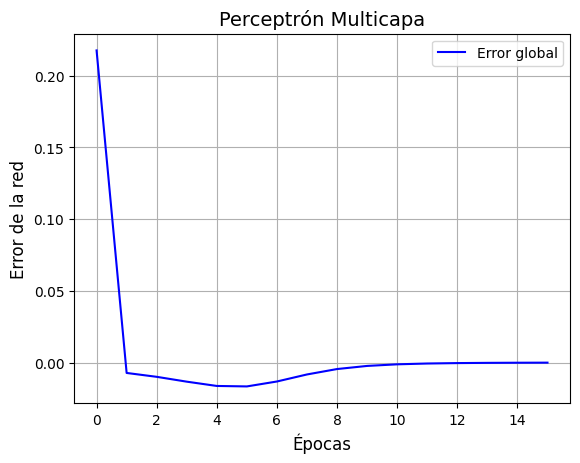

In [11]:
plt.grid()
plt.ylabel("Error de la red",fontsize=12)
plt.xlabel("Épocas",fontsize=12)
plt.title("Perceptrón Multicapa",fontsize=14)
x = np.arange(contadorEpocas)
plt.plot(x,E,'b',label="Error global")
plt.legend()
plt.show()

In [12]:
MatrizEntradas = Matriz(EntradasVal)
MatrizSalidas = Matriz(SalidasVal)
percetron = PerceptronMulticapa(MatrizEntradas,MatrizSalidas,PesoW1,PesoW2,ValBiaslSalida, ValBiasNeuOculta, precisionInicial, NumEpocas, factorAprendizaje, ContNeuCapaOculta, ContNeuCapaEntrada)

In [13]:
salidas = percetron.Validacion()
print("Salidas: ",salidas)
#asd = np.array(salidas)
#asd.shape

Salidas:  [[0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384], [0.9372658774281384],